In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crest-dataset/dataset/portable_executable.csv
/kaggle/input/crest-dataset/dataset/DLLs_Imported.csv
/kaggle/input/crest-dataset/dataset/API_Functions.csv
/kaggle/input/crest-dataset/dataset/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Importing Data

In [3]:
df = pd.read_csv('/kaggle/input/crest-dataset/dataset/API_Functions.csv')

In [4]:
# Show the dataset shape (rows, columns)
print(f"Dataset Shape: {df.shape}\n")

# Show the first 5 rows to get an overview
print("First 5 rows of the dataset:")
print(df.head(), "\n")

# Show column names and data types
print("\nColumn Data Types:")
print(df.dtypes, "\n")

# Show number of missing values per column (only if there are missing values)
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only columns with missing values
if not missing_values.empty:
    print("\nMissing Values Per Column:")
    print(missing_values, "\n")
else:
    print("\nNo missing values detected.\n")

# Show number of unique values for each column (Only for the first 50 columns to prevent overflow)
print("\nUnique Values Per Column (First 50 Columns):")
print(df.nunique().head(50), "\n")

# Show summary statistics for numerical columns (Only the first 50 columns)
print("\nSummary Statistics (First 50 Numerical Columns):")
print(df.describe().iloc[:, :50], "\n")  # Only first 50 columns to avoid overflow

# Detect categorical columns and show their unique values (only first 5 unique values per column)
cat_columns = df.select_dtypes(include=['object']).columns
if len(cat_columns) > 0:
    print("\nUnique Values for Categorical Columns:")
    for col in cat_columns:
        print(f"{col}: {df[col].unique()[:5]} ... (showing first 5 unique values)\n")
else:
    print("\nNo categorical columns detected.\n")

Dataset Shape: (28017, 21920)

First 5 rows of the dataset:
                                              SHA256  Type  getaclinformation  \
0  dacbe8cb72dd746539792a50e84965fefef73feaa07b5d...     0                  0   
1  d3dc7512ce75db33b2c3063fa99245e9ca9fe3b086462f...     0                  0   
2  b350fac81533f02981dc2176ed17163177d92d9405758e...     0                  0   
3  dfee618043a47b7b09305df0ca460559d9f567ee246c7b...     0                  0   
4  c7b2e4e4fb2fcc44c953673ff57c3d14bdf5d2008f35e9...     0                  0   

   getace  getsecuritydescriptordacl  regqueryvalueexa  regopenkeyexa  \
0       0                          0                 0              0   
1       0                          0                 0              0   
2       0                          0                 0              0   
3       0                          0                 0              0   
4       0                          0                 0              0   

   getsecurity

### Dataset Observations

**Shape:**

*   28,017 rows (samples)
*   21,920 columns (features)
*   Extremely high-dimensional, making direct training difficult.

**Column Types:**

*   `SHA256`: Identifier column (not useful for training).
*   `Type`: Target label (integer, ranges from 0 to 6).
*   Remaining columns: API function features, mostly binary (0 or 1).

**Key Problems:**

*   Too many features (21,920) → Curse of dimensionality.
*   Many features seem sparse (mostly 0s).
*   Feature selection/reduction is critical before model training.

In [5]:
# Drop the SHA256 column (identifier, not useful for ML)
df.drop(columns=["SHA256"], inplace=True)

# Verifying the change
print("Updated dataset shape:", df.shape)
# print("First 5 rows after dropping SHA256:\n", df.head(2))


Updated dataset shape: (28017, 21919)


## Checking for Redundant Features

Since the dataset has 21,919 features (excluding SHA256), identifying and removing redundant features is crucial.  Two primary methods will be employed:

1.  **Low-Variance Features:** Features that contain only a single value (or very close to it) provide no information for the model.  These will be removed.  This helps to eliminate features that are essentially constant.

2.  **Correlated Features:**  Highly correlated features carry similar information.  Keeping only one of a set of highly correlated features can simplify the model and improve training efficiency.  We will identify and remove features with high inter-correlation.  This addresses redundancy in the feature set.

### 1: Checking for Low-Variance Features

Our dataset primarily consists of binary features (0 = API not called, 1 = API called).  This means most columns represent whether a specific API call was made or not.

**What We Will Check For:**

We will identify and remove low-variance features.  Specifically, we'll look for features (columns) that have the same value for all rows (e.g., always 0 or always 1). These features provide no useful information for classification.

**Example:**

| feature_A | feature_B | feature_C |
|---|---|---|
| 0 | 1 | 0 |
| 0 | 1 | 0 |
| 0 | 1 | 0 |
| 0 | 1 | 0 |

In this example, `feature_C` is always 0, so it’s useless and should be removed.

**Impact on Model Performance:**

Too many irrelevant features can slow down training and increase the risk of overfitting. Removing these features speeds up processing without losing useful information.

**Relevance to Our Dataset:**

Since most of our columns are binary (0 or 1 for API calls), some API calls may never occur (resulting in a feature that is always 0). Removing such columns doesn’t change our classification ability—it only removes unnecessary data. If all API calls are used at least once (i.e., all features have both 0 and 1 values somewhere), then this step will likely not remove any features.

In [6]:
# Identify low-variance features (columns with a single unique value)
low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]

# Drop them from the dataset
df.drop(columns=low_variance_cols, inplace=True)

# Print results
print(f"Removed {len(low_variance_cols)} low-variance features.")
print("Updated dataset shape:", df.shape)


Removed 323 low-variance features.
Updated dataset shape: (28017, 21596)


### 2: Feature Selection Using Correlation

We will now identify and remove highly correlated features.

**Why?**

If two features are highly correlated (meaning their values tend to move together, either positively or negatively, close to +1 or -1 respectively), they provide almost the same information.  Keeping both features doesn't add much value to the model but *does* increase its complexity. Removing redundant features helps the model generalize better to unseen data and can also improve training speed.

**How We'll Do It:**

1.  **Compute Correlation Matrix:** We will calculate the correlation between all remaining features.  Given the large number of features (over 21,000), this will result in a large correlation matrix. This computation can be resource-intensive, so we will consider memory optimization strategies if necessary.

2.  **Identify Highly Correlated Features:** We will set a threshold (e.g., 0.95) for the absolute correlation value.  If the absolute correlation between two features is above this threshold, we will remove one of them. The rationale is that one feature effectively contains the same information as the other, so keeping both is redundant.  We'll need to decide which feature to keep (e.g., based on which one is more interpretable or has fewer missing values).

In [7]:
X = df.drop(columns=["Type"]) 

print(f"Dataset shape: {X.shape}")


Dataset shape: (28017, 21595)


## Optimizing Correlation Calculation for High-Dimensional Data

**What We Did:**

We faced a challenge: our dataset contained approximately 21,595 features, and calculating the full correlation matrix for such a large dataset was proving to be slow and memory-intensive. Computing correlations for all pairs of features at once was not feasible due to the computational cost and memory usage, especially when working with a dataset of this size.

**Optimization Approach:**

To address this, we implemented a *chunking* strategy. This involved breaking the dataset into smaller, manageable pieces (chunks) of 1000 features each. By computing the correlation matrix for these smaller chunks, we were able to significantly reduce memory usage and improve computation time. This approach allowed us to process the data incrementally, avoiding the need to load the entire dataset into memory at once. We also introduced **parallel processing** to distribute the computational load, speeding up the entire process.

### Code Implementation Details for Correlation-Based Feature Selection

**What We Do in the Code:**

Our code implements the correlation-based feature selection process with the following key strategies:

1. **Chunking the Data:** To avoid memory overload and accelerate processing, we split the dataset into smaller, manageable chunks (1000 features per chunk). This approach allows us to process the data in batches, preventing memory errors that could arise from processing the entire dataset at once.

2. **Parallel Processing:** To further optimize performance, we leverage the `ProcessPoolExecutor` to execute tasks concurrently across multiple CPU cores. This parallelization allows us to distribute the correlation calculations across different processes, reducing the overall computation time significantly—especially beneficial when working with high-dimensional data.

3. **Identifying and Removing Highly Correlated Features:** Within each chunk, we compute the correlation matrix and identify feature pairs with a correlation greater than 0.90 (our chosen threshold). We remove one feature from each pair of highly correlated features to reduce redundancy in the feature set. This step helps in improving model performance by preventing overfitting, and it also simplifies the dataset, making it easier to work with.

4. **Efficient Memory Usage:** We store the indices of features to be removed in a `set`. This data structure ensures that there are no duplicates, minimizing redundant calculations and reducing memory consumption. After processing all chunks, we drop the identified highly correlated features from the dataset.

**Why We Do It This Way:**

- **Speed:** Parallel processing drastically reduces the computation time. By distributing the workload across multiple cores, we complete the correlation analysis much faster compared to a sequential approach. This is particularly important when handling large datasets that would otherwise take an unreasonably long time to process.

- **Memory Efficiency:** Chunking is a crucial technique for managing memory usage. By processing the data in smaller chunks, we avoid loading the entire dataset into memory, which prevents potential memory overload errors and enables us to work with larger datasets efficiently.

- **Scalability:** This approach scales well with both increasing dataset size and available system resources. As data grows, we can handle larger datasets by adjusting the chunk size or increasing the number of parallel processes, ensuring the method remains efficient.

- **Model Optimization:** Removing highly correlated features is a key step in improving the performance of machine learning models. By eliminating redundant features, we reduce the risk of overfitting, enhance the generalizability of the model, and also make the model simpler and more interpretable.

In [8]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np

# Function to process each chunk (move lambda to a named function)
def process_chunk(chunk, chunk_size, X, chunk_index):
    # Compute the correlation matrix for the chunk
    print(f"Processing chunk {chunk_index}...")
    corr_matrix = chunk.corr().abs()
    
    # Select the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than 0.90
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
    
    print(f"Chunk {chunk_index} processed: Found {len(high_corr_features)} high-correlation features.")
    return high_corr_features

def compute_correlation_in_chunks_parallel(X, chunk_size=1000, num_workers=4):
    # Prepare tasks (each task is a tuple with chunk and necessary arguments)
    tasks = [(X.iloc[:, i:i+chunk_size], chunk_size, X, i // chunk_size + 1) for i in range(0, X.shape[1], chunk_size)]
    
    # Use ProcessPoolExecutor to execute the tasks in parallel
    high_corr_features = set()
    total_chunks = len(tasks)
    print(f"Starting parallel processing of {total_chunks} chunks.")
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for i, chunk_high_corr_features in enumerate(executor.map(process_chunk, *zip(*tasks))):
            high_corr_features.update(chunk_high_corr_features)
            print(f"Processed chunk {i+1}/{total_chunks} successfully.")
    
    print(f"Total high correlation features identified: {len(high_corr_features)}")
    return list(high_corr_features)

# Run the parallelized correlation calculation
high_corr_features = compute_correlation_in_chunks_parallel(X, chunk_size=1000, num_workers=4)

# Remove highly correlated features
X = X.drop(columns=high_corr_features)

print(f"Removed {len(high_corr_features)} highly correlated features.")
print(f"Updated dataset shape: {X.shape}")


Starting parallel processing of 22 chunks.
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Chunk 1 processed: Found 433 high-correlation features.
Processing chunk 4...
Processed chunk 1/22 successfully.
Processing chunk 5...
Chunk 2 processed: Found 404 high-correlation features.
Processed chunk 2/22 successfully.
Processing chunk 6...
Chunk 3 processed: Found 602 high-correlation features.
Processed chunk 3/22 successfully.
Processing chunk 7...
Chunk 4 processed: Found 792 high-correlation features.
Processed chunk 4/22 successfully.
Processing chunk 8...
Chunk 5 processed: Found 599 high-correlation features.
Processed chunk 5/22 successfully.
Processing chunk 9...
Chunk 6 processed: Found 782 high-correlation features.
Processed chunk 6/22 successfully.
Processing chunk 10...
Chunk 7 processed: Found 653 high-correlation features.
Processed chunk 7/22 successfully.
Processing chunk 11...
Chunk 8 processed: Found 858 high-correlation features.
Processed chunk 8/22

## Feature Selection

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [10]:
X = df.drop(columns=["Type"])  # Features
y = df["Type"]  # Target variable (malware type)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Selection Using Extra Trees for Malware Classification

### Challenge:
In our malware classification task, we were dealing with a high-dimensional dataset, especially with features related to API function calls. The challenge was to identify the most important features for model training while reducing the dimensionality and removing redundant information that could lead to overfitting.

### Solution:
To tackle this, we decided to use **Extra Trees**, an ensemble learning method, to perform **feature selection**. The Extra Trees algorithm offers several benefits in this context, including:
- Handling high-dimensional datasets effectively.
- Capturing non-linear relationships within the data.
- Reducing overfitting compared to other methods, such as Random Forest.

### Approach:

1. **Extra Trees Model Training**:
   We trained an `ExtraTreesClassifier` on our training data, which allowed us to assess the importance of each feature. The `ExtraTreesClassifier` uses multiple decision trees and averages the results to provide a robust feature importance score for each feature.

2. **Selecting Important Features**:
   After training, we extracted the **feature importances** from the model. These scores indicated which features contributed most to the model's predictions. We then selected features with importance scores above a predefined threshold (e.g., 0.05), which helped reduce the feature set while retaining the most informative variables.

3. **Training with Selected Features**:
   Using the selected features, we trained a new model and evaluated its performance on a test set. This process allowed us to compare how well the model performed with a reduced feature set versus using all features.

### Why We Chose Extra Trees:
- **Efficiency**: Extra Trees are well-suited for handling large datasets with many features, which is crucial in the case of API function data for malware classification.
- **Robustness**: Extra Trees are less prone to overfitting compared to other ensemble methods like Random Forest, making them a reliable choice for feature selection.
- **Scalability**: With parallelization and the ability to handle high-dimensional data, Extra Trees scales well with increasing dataset size and complexity.

### Results:
After applying Extra Trees for feature selection, we were able to reduce the feature set from over 21,000 features to around 5,500. This reduction helped:
- **Prevent overfitting** by removing highly correlated and redundant features.
- **Improve model training speed** by working with fewer features.
- **Simplify the model** while retaining most of the relevant information.

### Conclusion:
Using **Extra Trees** for feature selection provided an efficient, scalable way to handle the high-dimensional nature of the API function data. The approach helped us reduce complexity, improve model performance, and ensure the final model was both interpretable and effective for malware classification.


### Expected Results

We anticipate the following performance characteristics based on the number of selected features:

| Feature Count | Macro F1-Score | Training Time | Use Case |
|---|---|---|---|
| 500–1,000 | 0.88–0.91 | Fast | Real-time detection |
| 1,000–2,000 | 0.91–0.94 | Moderate | Balanced performance |
| 2,000–4,000 | 0.94–0.96 | Slow | Advanced threat detection |

These expected results suggest a trade-off between the number of features used, the resulting model performance (Macro F1-score), and the training time.  Fewer features lead to faster training and are suitable for real-time applications, while a larger number of features can potentially improve performance but at the cost of increased training time, making them more appropriate for advanced threat detection scenarios.


#### For our model we took top 1000 features due to time contrainst.

In [12]:
model = ExtraTreesClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_1000_features = importance_df.head(1000)

selected_feature_names = top_1000_features['Feature'].tolist()
# print(f"Top 1000 Selected Features: {selected_feature_names}")

X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]


In [13]:
print(X_train_selected.shape)
print(X_test_selected.shape)

(22413, 1000)
(5604, 1000)



Class Distribution (Count):
Type
4: BankingTrojan     4824
1: RedLineStealer    4785
3: RAT               4682
2: Downloader        4408
5: SnakeKeyLogger    4004
6: Spyware           3520
0: Benign            1794
Name: count, dtype: int64

Class Distribution (Percentage):
Type
4: BankingTrojan     17.218118
1: RedLineStealer    17.078916
3: RAT               16.711282
2: Downloader        15.733305
5: SnakeKeyLogger    14.291323
6: Spyware           12.563801
0: Benign             6.403255
Name: count, dtype: float64


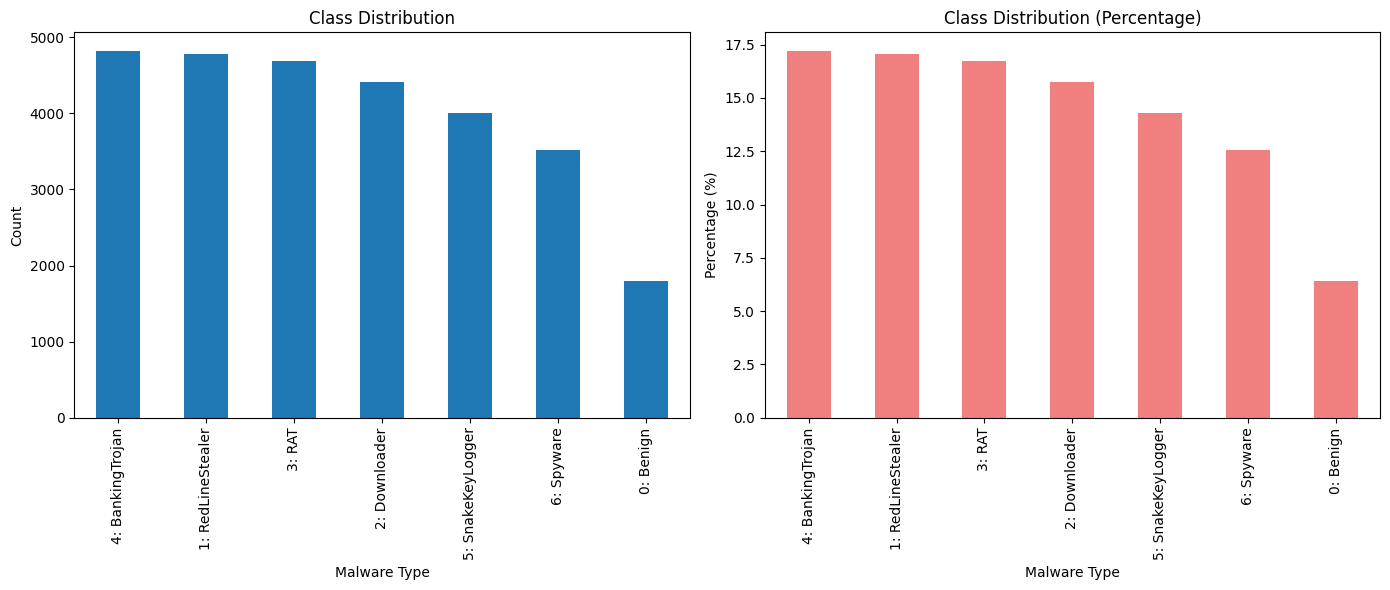

In [14]:
malware_names = {
    0: "0: Benign",
    1: "1: RedLineStealer",
    2: "2: Downloader",
    3: "3: RAT",
    4: "4: BankingTrojan",
    5: "5: SnakeKeyLogger",
    6: "6: Spyware"
}

# Get the distribution of the target labels
label_counts = df['Type'].value_counts()

# Map the numbers to names
label_names = label_counts.index.map(malware_names)  
label_counts.index = label_names

# Print the count of each class
print("\nClass Distribution (Count):")
print(label_counts)

# Calculate the percentage of each class
class_percentage = (label_counts / label_counts.sum()) * 100

# Print the percentage distribution
print("\nClass Distribution (Percentage):")
print(class_percentage)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

label_counts.plot(kind='bar', ax=ax[0], title='Class Distribution')
ax[0].set_xlabel("Malware Type")
ax[0].set_ylabel("Count")

class_percentage.plot(kind='bar', ax=ax[1], color='lightcoral', title='Class Distribution (Percentage)')
ax[1].set_xlabel("Malware Type")
ax[1].set_ylabel("Percentage (%)")

plt.tight_layout() 
plt.show()

#### Class Imbalance Analysis

Our dataset exhibits a significant class imbalance, with certain malware classes being substantially overrepresented compared to the Benign class.  This imbalance poses challenges for model training and evaluation.

**Key Observations:**

*   The Benign class is significantly underrepresented, comprising only 6.4% of the dataset.  This is a critical imbalance.
*   BankingTrojan, RedLineStealer, and RAT classes dominate the dataset, each containing over 4,000 samples.

**Impact of Class Imbalance:**

This class imbalance can lead to several issues during model training and evaluation:

*   **Model Bias:**  Models may become biased towards predicting the majority classes (the various malware types) due to their higher prevalence in the training data.  This can result in lower performance on the underrepresented Benign class.

*   **Overfitting Risk:** The limited number of Benign samples increases the risk of overfitting.  The model might not learn the true characteristics of benign files effectively, leading to poor generalization performance on unseen benign data.

*   **Evaluation Issues:**  Standard evaluation metrics like accuracy can be misleading in the presence of class imbalance.  A model could achieve high accuracy by simply predicting the majority class (malware) most of the time, even if it fails to correctly identify benign files. This highlights the need for more appropriate evaluation metrics, such as precision, recall, F1-score, and AUC-ROC, which are less sensitive to class imbalance.

In [15]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter 

print("\nClass Distribution Before SMOTE Resampling:")
print(Counter(y_train))

smote = SMOTE(sampling_strategy={0: 2000}, random_state=42)  # Upsample Benign to ~2k
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# New class distribution
from collections import Counter
print("\nClass Distribution After SMOTE Resampling:")
print(Counter(y_train_resampled))


Class Distribution Before SMOTE Resampling:
Counter({4: 3878, 1: 3819, 3: 3744, 2: 3503, 5: 3197, 6: 2821, 0: 1451})

Class Distribution After SMOTE Resampling:
Counter({4: 3878, 1: 3819, 3: 3744, 2: 3503, 5: 3197, 6: 2821, 0: 2000})


# Training Models

### Without Tuning

In [17]:
!pip install xgboost lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.4 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [18]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report,precision_recall_fscore_support

In [19]:
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_test_selected)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

print("\nModel Comparison:")
for model_name, metrics in results.items():
    print(f"{model_name}: {metrics}")


Training XGBoost...
XGBoost - Accuracy: 0.6759, Precision: 0.7893, Recall: 0.6759, F1 Score: 0.6596
Training RandomForest...
RandomForest - Accuracy: 0.6772, Precision: 0.7900, Recall: 0.6772, F1 Score: 0.6613
Training LightGBM...
LightGBM - Accuracy: 0.6779, Precision: 0.7928, Recall: 0.6779, F1 Score: 0.6616

Model Comparison:
XGBoost: {'accuracy': 0.6759457530335474, 'precision': 0.7893213157973246, 'recall': 0.6759457530335474, 'f1': 0.6596141317810809}
RandomForest: {'accuracy': 0.6771948608137045, 'precision': 0.7899573404382816, 'recall': 0.6771948608137045, 'f1': 0.6613245392729321}
LightGBM: {'accuracy': 0.67790863668808, 'precision': 0.7927610727972217, 'recall': 0.67790863668808, 'f1': 0.6615588932901553}


In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Initialize LightGBM model
lgbm_model = LGBMClassifier(random_state=42, verbose=-1)

# Train the model
print("Training LightGBM...")
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = lgbm_model.predict(X_test_selected)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Store results
results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
}

# Output the results
print(f"LightGBM - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

print("\nLightGBM Model Results:")
print(results)


Training LightGBM...
LightGBM - Accuracy: 0.6779, Precision: 0.7928, Recall: 0.6779, F1 Score: 0.6616

LightGBM Model Results:
{'accuracy': 0.67790863668808, 'precision': 0.7927610727972217, 'recall': 0.67790863668808, 'f1': 0.6615588932901553}


### With hyper parameter tuning

In [21]:
pip install xgboost lightgbm



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Random Forest

Fitting 5 folds for each of 20 candidates, totalling 100 fits

🔹 Best Parameters for Random Forest:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

🔹 Random Forest Classifier Performance Metrics:
✔️ Accuracy: 0.67719
✔️ Precision (Weighted): 0.78996
✔️ Recall (Weighted): 0.67719
✔️ F1-Score (Weighted): 0.66132
✔️ ROC-AUC Score: 0.90923
✔️ Log Loss: 0.86748

🔹 Confusion Matrix:
 [[142   1   2   5   1 192   0]
 [  1 857   2  17  75  14   0]
 [  5   5 892   2   1   0   0]
 [  1   5   1 406  10 510   5]
 [  1  51   1  19 702 170   2]
 [  9   9   1   1   2 777   8]
 [  0  13   0   1   1 665  19]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.41      0.57       343
           1       0.91      0.89      0.90       966
           2       0.99      0.99      0.99       905
           3       0.90      0.43      0.58       938
           4       0.89      0.74      0.81       946
       

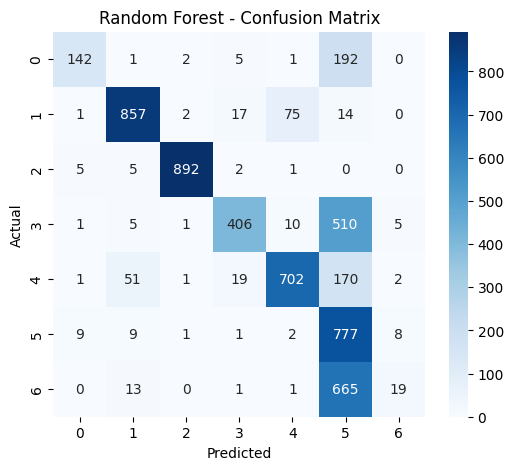

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
}

rf_model = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=20, 
    cv=5,  
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

random_search_rf.fit(X_train_resampled, y_train_resampled)

print("\n🔹 Best Parameters for Random Forest: ", random_search_rf.best_params_)

best_rf_model = random_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test_selected)
y_proba_rf = best_rf_model.predict_proba(X_test_selected)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr')
log_loss_rf = log_loss(y_test, y_proba_rf)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

class_report_rf = classification_report(y_test, y_pred_rf)

print(f"\n🔹 Random Forest Classifier Performance Metrics:")
print(f"✔️ Accuracy: {accuracy_rf:.5f}")
print(f"✔️ Precision (Weighted): {precision_rf:.5f}")
print(f"✔️ Recall (Weighted): {recall_rf:.5f}")
print(f"✔️ F1-Score (Weighted): {f1_rf:.5f}")
print(f"✔️ ROC-AUC Score: {roc_auc_rf:.5f}")
print(f"✔️ Log Loss: {log_loss_rf:.5f}")

print("\n🔹 Confusion Matrix:\n", conf_matrix_rf)
print("\n🔹 Classification Report:\n", class_report_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Random Forest - Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### XGBoost

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the hyperparameter space for RandomizedSearchCV
param_distributions_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Perform Randomized Search with Cross Validation
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=20,
    cv=5,
    n_jobs=1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

# Fit the model with the training data
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("\n🔹 Best Parameters for XGBoost: ", random_search_xgb.best_params_)

# Get the best model from RandomizedSearchCV
best_xgb_model = random_search_xgb.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test_selected)
y_proba_xgb = best_xgb_model.predict_proba(X_test_selected)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb, multi_class='ovr')
log_loss_xgb = log_loss(y_test, y_proba_xgb)

# Generate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Get classification report
class_report_xgb = classification_report(y_test, y_pred_xgb)

# Output the metrics
print(f"\n🔹 XGBoost Classifier Performance Metrics:")
print(f"✔️ Accuracy: {accuracy_xgb:.5f}")
print(f"✔️ Precision (Weighted): {precision_xgb:.5f}")
print(f"✔️ Recall (Weighted): {recall_xgb:.5f}")
print(f"✔️ F1-Score (Weighted): {f1_xgb:.5f}")
print(f"✔️ ROC-AUC Score: {roc_auc_xgb:.5f}")
print(f"✔️ Log Loss: {log_loss_xgb:.5f}")

# Print confusion matrix and classification report
print("\n🔹 Confusion Matrix:\n", conf_matrix_xgb)
print("\n🔹 Classification Report:\n", class_report_xgb)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("XGBoost - Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### LightGBM Model

In [24]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

param_distributions_lgbm = {
    'n_estimators': [100, 200],  
    'max_depth': [10, 15, 20], 
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2],  
    'learning_rate': [0.01, 0.05, 0.1]  
}

lgbm_model = LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions_lgbm,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    verbose=1,
    scoring='f1_weighted',
    random_state=42,
    return_train_score=True 
)


random_search_lgbm.fit(X_train_resampled, y_train_resampled)

best_lgbm_model = random_search_lgbm.best_estimator_

y_pred_lgbm = best_lgbm_model.predict(X_test_selected)
y_proba_lgbm = best_lgbm_model.predict_proba(X_test_selected)

accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')
roc_auc_lgbm = roc_auc_score(y_test, y_proba_lgbm, multi_class='ovr')
log_loss_lgbm = log_loss(y_test, y_proba_lgbm)

conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
class_report_lgbm = classification_report(y_test, y_pred_lgbm)

print("\nBest Parameters:", random_search_lgbm.best_params_)
print(f"\n🔹 LightGBM Classifier Performance Metrics:")
print(f"✔️ Accuracy: {accuracy_lgbm:.5f}")
print(f"✔️ Precision (Weighted): {precision_lgbm:.5f}")
print(f"✔️ Recall (Weighted): {recall_lgbm:.5f}")
print(f"✔️ F1-Score (Weighted): {f1_lgbm:.5f}")
print(f"✔️ ROC-AUC Score: {roc_auc_lgbm:.5f}")
print(f"✔️ Log Loss: {log_loss_lgbm:.5f}")

print("\n🔹 Confusion Matrix:\n", conf_matrix_lgbm)
print("\n🔹 Classification Report:\n", class_report_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("LightGBM - Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [25]:
from sklearn.linear_model import LogisticRegression
import numpy as np

base_predictions_train = [
    lgbm_model.predict_proba(X_train_resampled),
    best_rf_model.predict_proba(X_train_resampled)
]

# Stack predictions for meta-model training
X_train_meta = np.hstack(base_predictions_train)

# Train meta-model (Logistic Regression)
meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
meta_model.fit(X_train_meta, y_train_resampled)

# Generate base model predictions on test data
base_predictions_test = [
    lgbm_model.predict_proba(X_test_selected),
    best_rf_model.predict_proba(X_test_selected)
]

# Stack predictions for meta-model testing
X_test_meta = np.hstack(base_predictions_test)

# Predict using the trained meta-model
y_pred_ensemble = meta_model.predict(X_test_meta)

# Evaluate performance
print("\nClassification Report for Ensemble Model:")
print(classification_report(y_test, y_pred_ensemble))


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.92      0.41      0.57       343
           1       0.90      0.89      0.90       966
           2       0.99      0.98      0.99       905
           3       0.91      0.43      0.58       938
           4       0.88      0.73      0.80       946
           5       0.34      0.97      0.50       807
           6       0.56      0.03      0.05       699

    accuracy                           0.68      5604
   macro avg       0.79      0.64      0.63      5604
weighted avg       0.79      0.68      0.66      5604



In [26]:
import pandas as pd


pd.DataFrame(selected_feature_names, columns=['Feature']).to_csv("selected_features_api.csv", index=False)

print(" Selected features saved successfully in selected_features.csv!")


 Selected features saved successfully in selected_features.csv!


In [27]:
import pickle

# Create a dictionary with the models
models = {
    "meta_model": meta_model,  # Stacking meta-model (Logistic Regression)
    "best_rf": best_rf_model,  # Best Random Forest model
    "best_lgbm": lgbm_model  # Best LightGBM model
}

# Save the models dictionary to a single pickle file
with open("stacked_models_api.pkl", "wb") as f:
    pickle.dump(models, f)

print("All models saved successfully in 'stacked_models.pkl'!")


All models saved successfully in 'stacked_models.pkl'!
